In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [2]:
bist100=pd.read_excel("./excel/bist100.xlsx")
bist100=bist100["Kod"].values
for i in range(len(bist100)):
    bist100[i]=bist100[i]+".IS"

In [3]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()


In [4]:
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)

In [5]:
for i in range(len(hisseler)):
    hisseler[i]=hisseler[i]+".IS"

In [6]:
df=pd.DataFrame()
for hisse in hisseler:
    hisse_verileri = yf.download(hisse,start="2010-01-01")  # Örnek tarih aralığı
    hisse_kapanis = hisse_verileri[['High','Low','Open','Close','Volume']]
    hisse_kapanis["Hisse"]=hisse
    hisse_kapanis.loc[hisse_kapanis["Close"] > hisse_kapanis["High"], "High"] = hisse_kapanis["Close"]
    hisse_kapanis.loc[hisse_kapanis["Close"] < hisse_kapanis["Low"], "Low"] = hisse_kapanis["Close"]

    df=pd.concat([df,hisse_kapanis],axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,High,Low,Open,Close,Volume,Hisse
Date,,,,,,
2023-06-15,27.500000,27.500000,27.500000,27.500000,262214,A1CAP.IS
2023-06-16,30.240000,30.240000,30.240000,30.240000,1169499,A1CAP.IS
2023-06-20,31.100000,29.940001,31.000000,29.940001,8064437,A1CAP.IS
2023-06-21,26.959999,26.959999,26.959999,26.959999,2147415,A1CAP.IS
2023-06-22,27.620001,25.500000,25.620001,25.940001,71898180,A1CAP.IS
...,...,...,...,...,...,...
2024-05-28,7.270000,7.040000,7.170000,7.220000,1321881,ZRGYO.IS
2024-05-29,7.610000,7.220000,7.220000,7.390000,4984541,ZRGYO.IS
2024-05-30,7.970000,7.220000,7.590000,7.890000,11925383,ZRGYO.IS


In [7]:
ddata=df.copy()

In [8]:
df["Volume"]=df["Close"]*df["Volume"]

In [9]:
df["Close"]=np.round(df["Close"],2)
df["High"]=np.round(df["High"],2)
df["Low"]=np.round(df["Low"],2)
df["Open"]=np.round(df["Open"],2)

In [10]:
df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']

In [11]:
df["Kademe"] = np.where(df["Adj Close"] < 20, 0.01,
                np.where(df["Adj Close"] < 50, 0.02,
                    np.where(df["Adj Close"] < 100, 0.05,
                        np.where(df["Adj Close"] < 250, 0.1,
                            np.where(df["Adj Close"] < 500, 0.25,
                                np.where(df["Adj Close"] < 1000, 0.5,
                                    np.where(df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )


In [12]:
df=df.dropna()

In [13]:
import math
def yuvarla_asagi(row):
    fiyat = row['Adj Close']
    kadem = row['Kademe']
    return math.floor(fiyat * 1.1 / kadem) * kadem

df["Tavan"]=df.apply(yuvarla_asagi, axis=1)
df["Tavan"]=np.round(df["Tavan"],2)

In [14]:
df["Tavan Kontrol"]=np.where(((df["Adj Close"]/df["Tavan"].shift(1))==1),1,0)
df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Tavan Kontrol
Date,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0.02,30.24,0
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,0.02,33.26,1
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0.02,32.92,0
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0.02,29.64,0
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0.02,28.52,0
...,...,...,...,...,...,...,...,...,...
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0.01,7.94,0
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0.01,8.12,0
2024-05-30,7.97,7.22,7.59,7.89,9.409127e+07,ZRGYO.IS,0.01,8.67,0


In [15]:
df=df.drop(["Kademe","Tavan"],axis=1)

In [22]:
ta.bbands(df["Adj Close"],20,2).iloc[:,:3]

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0
Date,,,
2023-06-15,NaN,NaN,NaN
2023-06-16,NaN,NaN,NaN
2023-06-20,NaN,NaN,NaN
2023-06-21,NaN,NaN,NaN
2023-06-22,NaN,NaN,NaN
...,...,...,...
2024-05-28,6.757255,7.2810,7.804745
2024-05-29,6.757359,7.2815,7.805641
2024-05-30,6.729725,7.3155,7.901275


In [30]:
df["Williams%R"]=ta.willr(df["High"],df["Low"],df["Adj Close"],21)

In [33]:
df["Aroon 1"]=ta.aroon(df["High"],df["Low"],14).iloc[:,0]
df["Aroon 2"]=ta.aroon(df["High"],df["Low"],14).iloc[:,1]
df["Aroon 3"]=ta.aroon(df["High"],df["Low"],14).iloc[:,2]

In [26]:
df["BB Low"]=ta.bbands(df["Adj Close"],20,2).iloc[:,0]
df["BB Mid"]=ta.bbands(df["Adj Close"],20,2).iloc[:,1]
df["BB Up"]=ta.bbands(df["Adj Close"],20,2).iloc[:,2]


In [36]:
df["ATR"]=ta.atr(df["High"],df["Low"],df["Adj Close"],14)

In [38]:
import pandas_ta as ta
df["RSI"]=ta.rsi(df["Adj Close"],14)
df["SMA 5"]=df["Adj Close"].rolling(5).mean()
df["SMA 10"]=df["Adj Close"].rolling(5).mean()
df["SMA 200"]=df["Adj Close"].rolling(5).mean()




df["Bağıl Hacim"] = df["Volume"] / df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(df["High"], df["Low"], df["Adj Close"], 14)
df["ADX"], df["DMIP"], df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

df = calculate_stoch_rsi(df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

df = calculate_macd(df)



# Diğer Göstergeler
df["DD"] = ((df["Adj Close"] / df["High"]) - 1) * 100
df["Range"] = ((df["High"] - df["Low"]) / df["Adj Close"]) * 100

df["MOM"] = ta.mom(df["Adj Close"], 10)



df["Driehaus Momentum"] = ((df["Bağıl Hacim"] > 2) & (df["RSI"] > 50) & (df["MOM"] > 1) & (df["Adj Close"] > df["SMA 5"]) & (df["Adj Close"] > df["SMA 10"]) & (df["Adj Close"] > df["SMA 200"])).astype(int)
df["MACD Yukarı Kesen"] = ((df["Bağıl Hacim"] > 1.5) & (df["MACD"] > 0) & (df["MACD_above_Signal"] == 1)).astype(int)
df["ADXDMI20"] = ((df["Bağıl Hacim"] > 1.3) & (df["ADX"] > 20) & (df["DMIP"] > df["DMIN"])).astype(int)
df["MACD+Stoch"] = ((df["Bağıl Hacim"] > 1.3) & (df["StochRSI_%K"] > df["StochRSI_%D"]) & (df["MACD_above_Signal"] == 1)).astype(int)




In [39]:
df["Return"]=100*((df["Open"]/df["Adj Close"].shift(2))-1)
df["Return"]=df["Return"].shift(-2)
df["Date"]=pd.to_datetime(df.index)
df


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,BB Low,BB Mid,BB Up,...,MACD_above_Signal,DD,Range,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,Return,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,0.0,0.000000,0.000000,NaN,0,0,0,0,12.727273,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,0.0,0.000000,0.000000,NaN,0,0,0,0,-10.846561,2023-06-16
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,0.0,-3.729904,3.874415,NaN,0,0,0,0,-14.428858,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,0.0,0.000000,0.000000,NaN,0,0,0,0,-3.041543,2023-06-21
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,NaN,NaN,...,0.0,-6.082549,8.172706,NaN,0,0,0,0,-0.154202,2023-06-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0,6.757255,7.2810,7.804745,...,0.0,-0.687758,3.185596,0.31,0,0,0,0,5.124654,2024-05-28
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0,6.757359,7.2815,7.805641,...,0.0,-2.890933,5.277402,0.46,0,0,1,0,7.036536,2024-05-29
2024-05-30,7.97,7.22,7.59,7.89,9.409127e+07,ZRGYO.IS,0,6.729725,7.3155,7.901275,...,1.0,-1.003764,9.505703,0.75,0,1,1,1,3.422053,2024-05-30


In [41]:
endeks=yf.download(tickers="XU100.IS",start="2000-01-01")
df["Endeks"]=endeks["Adj Close"]
df["Endeks Return"]=100*((df["Endeks"]/df["Endeks"].shift(1))-1)
df["Return Lag"]=((df["Adj Close"]/df["Adj Close"].shift(1))-1)*100
df

[*********************100%%**********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,BB Low,BB Mid,BB Up,...,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,Return,Date,Endeks,Endeks Return,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,12.727273,2023-06-15,5495.500000,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,NaN,0,0,0,0,-10.846561,2023-06-16,5475.500000,-0.363934,9.963636
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-14.428858,2023-06-20,5251.600098,-4.089122,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-3.041543,2023-06-21,5186.799805,-1.233915,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-0.154202,2023-06-22,5428.299805,4.656050,-3.783383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0,6.757255,7.2810,7.804745,...,0.31,0,0,0,0,5.124654,2024-05-28,10677.500000,0.192362,0.697350
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0,6.757359,7.2815,7.805641,...,0.46,0,0,1,0,7.036536,2024-05-29,10479.200195,-1.857174,2.354571
2024-05-30,7.97,7.22,7.59,7.89,9.409127e+07,ZRGYO.IS,0,6.729725,7.3155,7.901275,...,0.75,0,1,1,1,3.422053,2024-05-30,10481.299805,0.020036,6.765900


In [42]:
df=df.sort_index()

In [314]:
result = df.groupby('Hisse').apply(lambda x: x.iloc[2:])
result=result.droplevel(0)
result

,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,BB Low,BB Mid,BB Up,...,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,Return,Date,Endeks,Endeks Return,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-14.428858,2023-06-20,5251.600098,-4.089122,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-3.041543,2023-06-21,5186.799805,-1.233915,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-0.154202,2023-06-22,5428.299805,4.656050,-3.783383
2023-06-23,26.60,25.70,26.14,25.90,5.159935e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,0.000000,2023-06-23,5582.799805,2.846195,-0.154202
2023-06-26,26.40,25.84,25.90,25.90,3.380095e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-0.694981,2023-06-26,5732.899902,2.688617,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0,6.757255,7.2810,7.804745,...,0.31,0,0,0,0,5.124654,2024-05-28,10677.500000,0.192362,0.697350
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0,6.757359,7.2815,7.805641,...,0.46,0,0,1,0,7.036536,2024-05-29,10479.200195,-1.857174,2.354571
2024-05-30,7.97,7.22,7.59,7.89,9.409127e+07,ZRGYO.IS,0,6.729725,7.3155,7.901275,...,0.75,0,1,1,1,3.422053,2024-05-30,10481.299805,0.020036,6.765900


In [44]:


yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [318]:

result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result.sort_index()
result=result[result["Hisse"].isin(bist100)]
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc[:"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_test=test.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_val=val.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_train=X_train[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
X_test=X_test[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [319]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

def objective(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }
    

    model = CatBoostRegressor(**param, verbose=0,random_seed=123,task_type="GPU")

    # Modeli eğitme
    model.fit(X_train, y_train)





    

    model.fit(X_train, y_train)

        

    tahminler=pd.DataFrame(scaler2.inverse_transform(np.array(val["Return"]).reshape(-1,1)))
    tahminler=tahminler.set_index(X_val.index)
    tahminler["Tahmin"]=scaler2.inverse_transform(np.array(model.predict(X_val)).reshape(-1,1))
    tahminler.columns=["Gerçek","Tahmin"]
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Tavan"]=val["Tavan Kontrol"]
    tahminler=tahminler[tahminler["Tavan"]==0]
    tahminler=tahminler[tahminler["Hisse"].isin(bist100)]
    top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(1, columns=['Tahmin'])).dropna()
    topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2).iloc[-1]
    returns=(top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2).diff().dropna()

    sharpe=topkar/returns.std()
    metrik=sharpe*topkar

    
    
        
       
    

    
    return metrik


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # n_trials, denenecek hiperparametre kombinasyonu sayısı

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


[I 2024-06-04 00:33:05,617] A new study created in memory with name: no-name-e290cbe8-f919-4a17-9270-746537981a6d
[I 2024-06-04 00:33:13,065] Trial 0 finished with value: 10896.43099578547 and parameters: {'iterations': 413, 'depth': 5, 'learning_rate': 0.26510331579319185, 'random_strength': 12, 'bagging_temperature': 0.625530745876702, 'border_count': 161, 'l2_leaf_reg': 21}. Best is trial 0 with value: 10896.43099578547.
[I 2024-06-04 00:33:22,688] Trial 1 finished with value: 10620.878437869695 and parameters: {'iterations': 396, 'depth': 9, 'learning_rate': 0.025508467570344126, 'random_strength': 16, 'bagging_temperature': 0.5664378108105208, 'border_count': 176, 'l2_leaf_reg': 24}. Best is trial 0 with value: 10896.43099578547.
[I 2024-06-04 00:33:39,890] Trial 2 finished with value: 12563.977185816586 and parameters: {'iterations': 907, 'depth': 5, 'learning_rate': 0.08606578973810135, 'random_strength': 1, 'bagging_temperature': 0.5664181238042411, 'border_count': 136, 'l2_lea

En iyi parametreler:  {'iterations': 448, 'depth': 5, 'learning_rate': 0.0703865795127859, 'random_strength': 1, 'bagging_temperature': 0.3281753446080507, 'border_count': 235, 'l2_leaf_reg': 23}
En iyi skor:  14827.309811856207


In [313]:
params ={'iterations': 363, 'depth': 9, 'learning_rate': 0.022966443559949937, 'random_strength': 13, 'bagging_temperature': 0.6758282260679829, 'border_count': 211, 'l2_leaf_reg': 18}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/bist100scaling.bin")

In [24]:
params = {'iterations': 629, 'depth': 8, 'learning_rate': 0.03984954027131234, 'random_strength': 3, 'bagging_temperature': 0.39823126184519836, 'border_count': 229, 'l2_leaf_reg': 19}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/xtumykapanis.bin")

In [53]:
bist100=pd.read_excel("./excel/bist100.xlsx")
bist100=bist100["Kod"].values
for i in range(len(bist100)):
    bist100[i]=bist100[i]+".IS"

In [25]:
bist30=pd.read_excel("./excel/bist30.xlsx")
bist30=bist30["Kod"].values
for i in range(len(bist30)):
    bist30[i]=bist30[i]+".IS"

In [63]:
tahminler=pd.DataFrame()
tahminler["Gerçek"]=test["Return"]
tahminler["Tahmin"]=model.predict(X_test)
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Hisse"].isin(bist100)]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(2, columns=['Tahmin'])).dropna()
(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)


Date
2024-01-02    -1.643553
2024-01-03    -1.461545
2024-01-04    -1.715857
2024-01-05     1.354101
2024-01-08     1.660830
                ...    
2024-05-24    50.311079
2024-05-27    50.645237
2024-05-28    50.926135
2024-05-29    50.409356
2024-05-30    52.808697
Name: Gerçek, Length: 103, dtype: float64

In [88]:
top_5_rows1=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.4

In [64]:
kar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).iloc[-1]
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()

sharpe=kar/returns.std()
sharpe

32.79618326702107

In [808]:
sharpes=[]
metrik=[]
adet=[]
karlar=[]
for i in range(1,30):
   top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(i, columns=['Tahmin'])).dropna()
   topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).iloc[-1]
   returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()
   sharpe=topkar/returns.std()
   metrik.append(sharpe*topkar)
   sharpes.append(sharpe)
   adet.append(i)
   karlar.append(topkar)
sonuc=pd.DataFrame()
sonuc["Adet"]=adet
sonuc["Sharpe*Kar"]=metrik
sonuc["Sharpe"]=sharpes
sonuc["Kar"]=karlar
sonuc.sort_values(by="Kar",ascending=False)


,Adet,Sharpe*Kar,Sharpe,Kar
0,1,8349.412711,45.867202,182.034490
1,2,6084.210989,46.243874,131.567936
2,3,6705.152795,53.561270,125.186590
3,4,5849.274370,54.508067,107.310252
4,5,6757.337233,64.573737,104.645287
5,6,6158.290415,66.360794,92.800132
6,7,6101.233141,69.467187,87.828994
7,8,4821.732780,64.258774,75.036178
8,9,4763.287935,64.309135,74.068605
9,10,4947.911120,67.535264,73.264112


In [65]:
top_5_rows=top_5_rows.droplevel(level=0)


In [66]:
indexler=df.index.unique()

In [28]:
window_size=range(2,100)
vars=[]
top_5_rows["Var"]=0
size=[]
toplamkar=[]
import pandas as pd
for window in window_size:
   for index, group in top_5_rows.loc[:"2024-05-29"].groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-window:]
              getiriler=window_data.pct_change(window-1)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=std/getiri
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
   veri=top_5_rows[top_5_rows["Var"]>0]
   metrik=veri["Var"]
   veri["Metrik"]=metrik
   veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
   veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
   topkar=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
   toplamkar.append(topkar.iloc[-1])
   size.append(window)
   print("Window:{} Kar:{}".format(window,topkar.iloc[-1]))
optimizer=pd.DataFrame()
optimizer["Window Size"]=size
optimizer["Return"]=toplamkar
optimizer=optimizer.sort_values(by="Return",ascending=False)
optimizer





Window:2 Kar:69.2865826567482
Window:3 Kar:55.48788603939144
Window:4 Kar:69.09480591173319
Window:5 Kar:66.22385396495899
Window:6 Kar:73.14294351272686
Window:7 Kar:73.34978060127796
Window:8 Kar:97.73189611997005
Window:9 Kar:81.17208730431715
Window:10 Kar:99.81830540200497
Window:11 Kar:74.31264786300889
Window:12 Kar:80.19083843331325
Window:13 Kar:65.40446712345688
Window:14 Kar:77.29850468584495
Window:15 Kar:81.47366089515432
Window:16 Kar:71.94454231979421


: 

In [91]:

vars=[]
top_5_rows["Var"]=0

for index, group in top_5_rows.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-19:]
              getiriler=window_data.pct_change(18)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows[top_5_rows["Var"]>0]
veri=veri[veri["Tahmin"]>0]
metrik=veri["Var"]*veri["Tahmin"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
topkar






Date
2024-01-02     -0.511322
2024-01-03      0.307163
2024-01-04      0.761636
2024-01-05      4.700408
2024-01-08      8.543844
                 ...    
2024-05-22    148.045518
2024-05-23    148.463279
2024-05-24    149.686142
2024-05-27    150.517319
2024-05-28    151.469914
Name: Ağırlıklı Getiri, Length: 99, dtype: float64

In [92]:

vars=[]
top_5_rows1["Var"]=0

for index, group in top_5_rows1.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-19:]
              getiriler=window_data.pct_change(18)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows1.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows1[top_5_rows1["Var"]>0]
veri=veri[veri["Tahmin"]>0]
metrik=veri["Var"]*veri["Tahmin"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar1=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
topkar1






Date
2024-01-02     -0.711322
2024-01-03     -0.092837
2024-01-04      0.161636
2024-01-05      3.900408
2024-01-08      7.543844
                 ...    
2024-05-22    129.045518
2024-05-23    129.263279
2024-05-24    130.286142
2024-05-27    130.917319
2024-05-28    131.669914
Name: Ağırlıklı Getiri, Length: 99, dtype: float64

In [93]:
endeks=yf.download(tickers="XU100.IS",start="2023-12-29")
endeks["Getiri"]=0
for i in range(len(endeks)):
    endeks["Getiri"].iloc[i]=100*((endeks["Adj Close"].iloc[i]/endeks["Adj Close"].iloc[0])-1)
endeks=endeks.fillna(0)
endeks

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2023-12-29,7415.299805,7510.399902,7415.299805,7470.200195,7470.200195,2664606500,0.000000
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,2.062858
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-0.779098
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,1.038789
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,2.121764
...,...,...,...,...,...,...,...
2024-05-27,10701.200195,10758.900391,10584.599609,10657.000000,10657.000000,2655557300,42.660166
2024-05-28,10678.799805,10721.200195,10589.700195,10677.500000,10677.500000,2872255400,42.934590
2024-05-29,10688.599609,10714.700195,10464.900391,10479.200195,10479.200195,2505729800,40.280045


In [94]:
bank=yf.download(tickers="XBANK.IS",start="2023-12-29")
bank["Getiri"]=0
for i in range(len(bank)):
    bank["Getiri"].iloc[i]=100*((bank["Adj Close"].iloc[i]/bank["Adj Close"].iloc[0])-1)
bank=bank.fillna(0)
bank

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2023-12-29,8524.700195,8774.500000,8520.200195,8717.200195,8717.200195,1235400,0.000000
2024-01-02,8829.599609,8894.000000,8682.000000,8768.000000,8768.000000,767100,0.582754
2024-01-03,8750.500000,8785.799805,8489.299805,8489.299805,8489.299805,591700,-2.614376
2024-01-04,8498.000000,8727.500000,8392.599609,8711.500000,8711.500000,816400,-0.065390
2024-01-05,8720.599609,8790.700195,8644.599609,8789.900391,8789.900391,619100,0.833986
...,...,...,...,...,...,...,...
2024-05-27,15112.900391,15299.099609,14868.799805,15172.200195,15172.200195,707100,74.049005
2024-05-28,15209.900391,15509.599609,15128.599609,15456.299805,15456.299805,788500,77.308074
2024-05-29,15482.500000,15512.700195,14964.900391,14964.900391,14964.900391,663900,71.670950


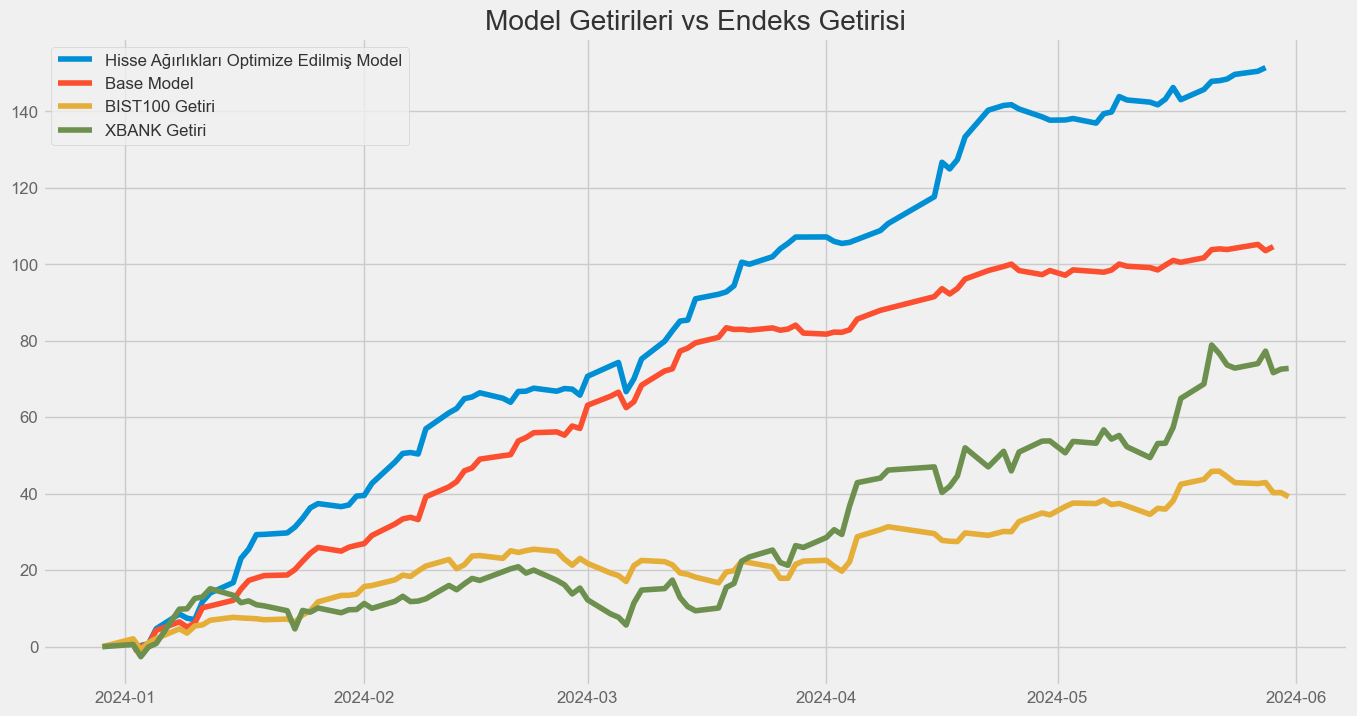

In [95]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirileri vs Endeks Getirisi")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Base Model")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
plt.plot(bank["Getiri"],label="XBANK Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

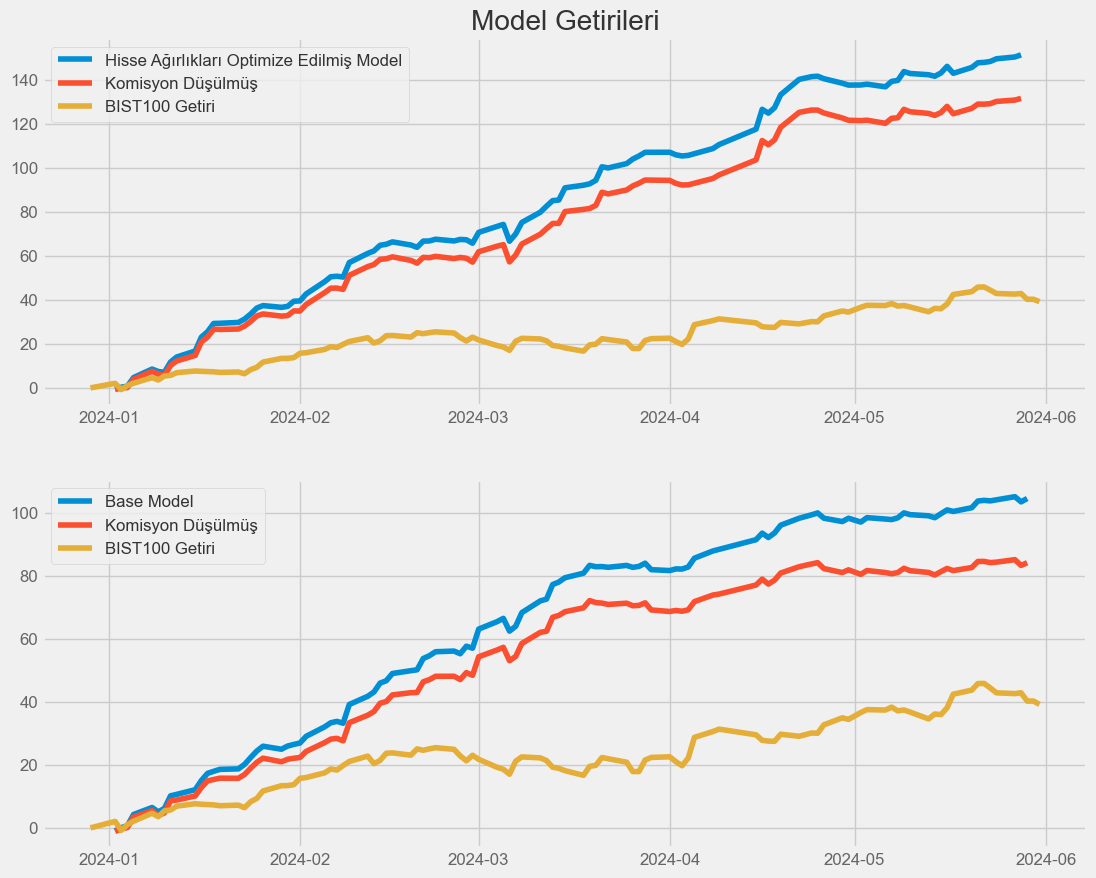

In [96]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title("Model Getirileri")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(topkar1,label="Komisyon Düşülmüş")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")

plt.legend()
plt.subplot(2,1,2)
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Base Model")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Komisyon Düşülmüş")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
plt.legend()

In [815]:
kar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).iloc[-1]
returns=topkar.diff().dropna()

sharpe=topkar.iloc[-1]/returns.std()
sharpe

60.58480147365528

In [462]:
xtumy=pd.read_csv("BIST Tüm - 100 Geçmiş Verileri (8).csv")
xtumy=xtumy[::-1]
xtumy=xtumy.set_index(pd.to_datetime(yf.download(tickers="XU100.IS",start="2024-01-02",end="2024-05-30").index))
xtumy["Şimdi"]=xtumy["Şimdi"].str.replace(".","")
xtumy["Şimdi"]=xtumy["Şimdi"].str.replace(",",".")
xtumy["Şimdi"]=xtumy["Şimdi"].astype(float)
xtumy["Getiri"]=xtumy["Şimdi"].pct_change()*100
xtumy=xtumy.fillna(0)
xtumy

[*********************100%%**********************]  1 of 1 completed


,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %,Getiri
Date,,,,,,,,
2024-01-02,02.01.2024,26500.00,"25.981,61","26.559,05","25.981,61","1,51B","2,83%",0.000000
2024-01-03,03.01.2024,25773.09,"26.536,36","26.536,36","25.754,93","1,52B","-2,74%",-2.743057
2024-01-04,04.01.2024,26092.83,"25.774,39","26.092,83","25.601,14","1,24B","1,24%",1.240596
2024-01-05,05.01.2024,26632.97,"26.144,43","26.632,97","26.084,65","1,57B","2,07%",2.070071
2024-01-08,08.01.2024,27018.79,"26.762,93","27.026,95","26.762,93","1,61B","1,45%",1.448656
...,...,...,...,...,...,...,...,...
2024-05-23,23.05.2024,35926.66,"36.200,74","36.334,22","35.926,66","3,17B","-0,73%",-0.734928
2024-05-24,24.05.2024,35557.56,"35.975,05","36.006,72","35.514,53","2,62B","-1,03%",-1.027371
2024-05-27,27.05.2024,34941.10,"35.613,19","35.652,49","34.901,16","3,07B","-1,73%",-1.733696


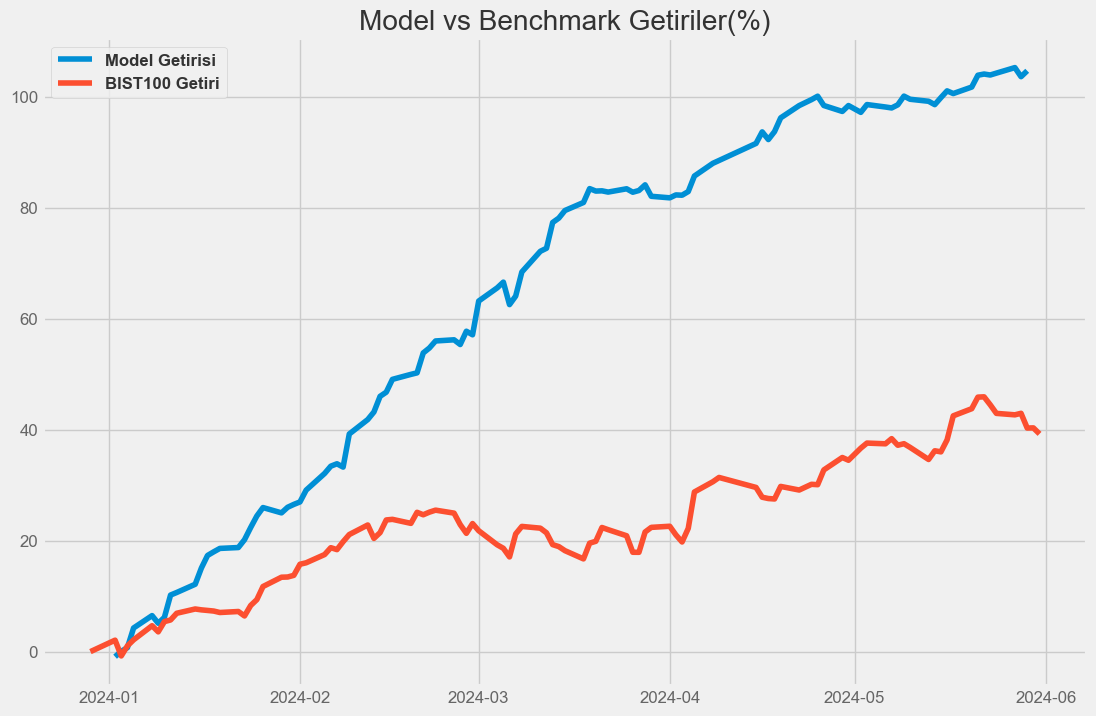

In [816]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("Model vs Benchmark Getiriler(%)")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Model Getirisi")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

In [817]:
veri["Para"]=100000*veri["Ağırlık"]
veri.groupby("Date")["Para"].sum()
veri["Fiyat"]=0
for i in range(len(veri)):
    hisse=veri["Hisse"].iloc[i]
    time=pd.to_datetime(veri.index[i])
    fiyat=df[df["Hisse"]==hisse].loc[time]["Adj Close"]
    veri["Fiyat"].iloc[i]=fiyat
veri["Lot"]=veri["Para"]//veri["Fiyat"]

Date
2024-01-02    100000.0
2024-01-03    100000.0
2024-01-04    100000.0
2024-01-05    100000.0
2024-01-08    100000.0
                ...   
2024-05-24    100000.0
2024-05-27    100000.0
2024-05-28    100000.0
2024-05-30    100000.0
2024-05-31    100000.0
Name: Para, Length: 101, dtype: float64

In [818]:
ağırlıklar=((100*(veri.loc[:"2024-05-29"].groupby('Hisse')["Para"].sum().sort_values(ascending=True)/veri.loc[:"2024-05-29"]["Para"].sum())))
plt.figure(figsize=(12,10))
plt.title("Yatırılan Toplam Paranın Hisselere Göre Dağılımı(%)")
plt.barh(ağırlıklar.tail(30).index,ağırlıklar.tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'AKYHO.IS'),
  Text(0, 1, 'DOFER.IS'),
  Text(0, 2, 'TDGYO.IS'),
  Text(0, 3, 'BASGZ.IS'),
  Text(0, 4, 'AGROT.IS'),
  Text(0, 5, 'MAGEN.IS'),
  Text(0, 6, 'BSOKE.IS'),
  Text(0, 7, 'MAVI.IS'),
  Text(0, 8, 'IHAAS.IS'),
  Text(0, 9, 'DESPC.IS'),
  Text(0, 10, 'ESCAR.IS'),
  Text(0, 11, 'ZEDUR.IS'),
  Text(0, 12, 'GRSEL.IS'),
  Text(0, 13, 'METUR.IS'),
  Text(0, 14, 'KTLEV.IS'),
  Text(0, 15, 'PAPIL.IS'),
  Text(0, 16, 'ERSU.IS'),
  Text(0, 17, 'BMSTL.IS'),
  Text(0, 18, 'ANHYT.IS'),
  Text(0, 19, 'SELGD.IS'),
  Text(0, 20, 'TSGYO.IS'),
  Text(0, 21, 'RALYH.IS'),
  Text(0, 22, 'MTRKS.IS'),
  Text(0, 23, 'RAYSG.IS'),
  Text(0, 24, 'JANTS.IS'),
  Text(0, 25, 'PINSU.IS'),
  Text(0, 26, 'BAYRK.IS'),
  Text(0, 27, 'TRILC.IS'),
  Text(0, 28, 'IZFAS.IS'),
  Text(0, 29, 'UFUK.IS')])

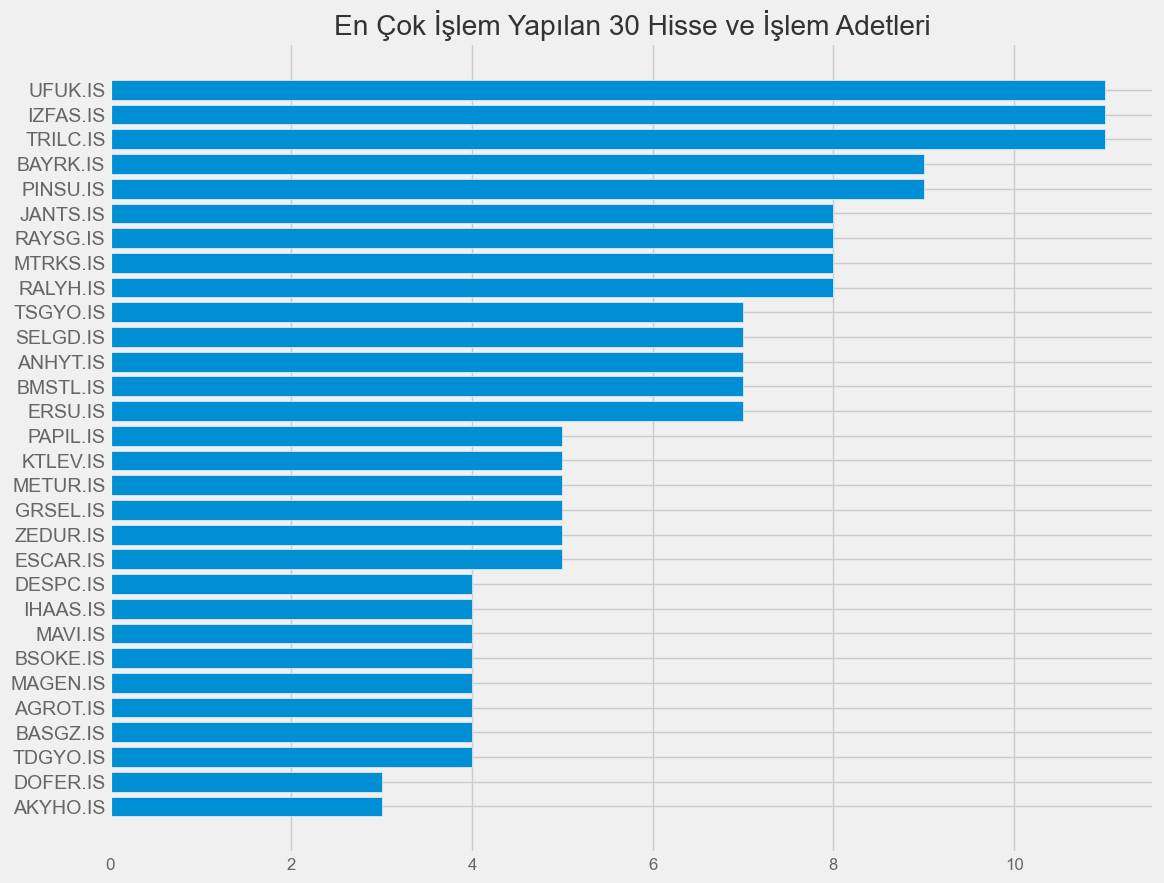

In [820]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(veri["Hisse"].value_counts().sort_values().tail(30).index,veri["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [821]:

returns=topkar.diff().dropna()
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Ağırlıklı Getiri,Kar
Date,,
2024-01-03,0.008185,1
2024-01-04,0.004545,1
2024-01-05,0.039388,1
2024-01-08,0.038434,1
2024-01-09,-0.010874,0
...,...,...
2024-05-22,0.001610,1
2024-05-23,0.004178,1
2024-05-24,0.012229,1


In [822]:
returns["Ağırlıklı Getiri"].mean()*100

1.550828943355797

In [823]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kazanma serisi uzunluğu:", ortalama)


Ortalama kazanma serisi uzunluğu: 5.066666666666666


In [824]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", ortalama)


Ortalama kaybetme serisi uzunluğu: 1.5714285714285714


In [825]:
endeks["Return"]=(endeks["Adj Close"]/endeks["Adj Close"].shift(1))-1
endeks

,Open,High,Low,Close,Adj Close,Volume,Getiri,Return
Date,,,,,,,,
2023-12-29,7415.299805,7510.399902,7415.299805,7470.200195,7470.200195,2664606500,0.000000,NaN
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,2.062858,0.020629
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-0.779098,-0.027845
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,1.038789,0.018322
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,2.121764,0.010718
...,...,...,...,...,...,...,...,...
2024-05-27,10701.200195,10758.900391,10584.599609,10657.000000,10657.000000,2655557300,42.660166,-0.001845
2024-05-28,10678.799805,10721.200195,10589.700195,10677.500000,10677.500000,2872255400,42.934590,0.001924
2024-05-29,10688.599609,10714.700195,10464.900391,10479.200195,10479.200195,2505729800,40.280045,-0.018572


In [826]:
endeks["Kar"]=np.where((endeks["Return"]>0),1,0)
xtumy["Kar"]=np.where((xtumy["Getiri"]>0),1,0)

In [795]:
returns[returns["Ağırlıklı Getiri"]>0]

,Ağırlıklı Getiri,Kar
Date,,
2024-01-03,0.014883,1
2024-01-04,0.016763,1
2024-01-05,0.021555,1
2024-01-08,0.010459,1
2024-01-09,0.014968,1
...,...,...
2024-05-17,0.002499,1
2024-05-20,0.011620,1
2024-05-21,0.022876,1


In [ ]:
qs.reports.full(returns=returns["Ağırlıklı Getiri"],benchmark=endeks["Return"])

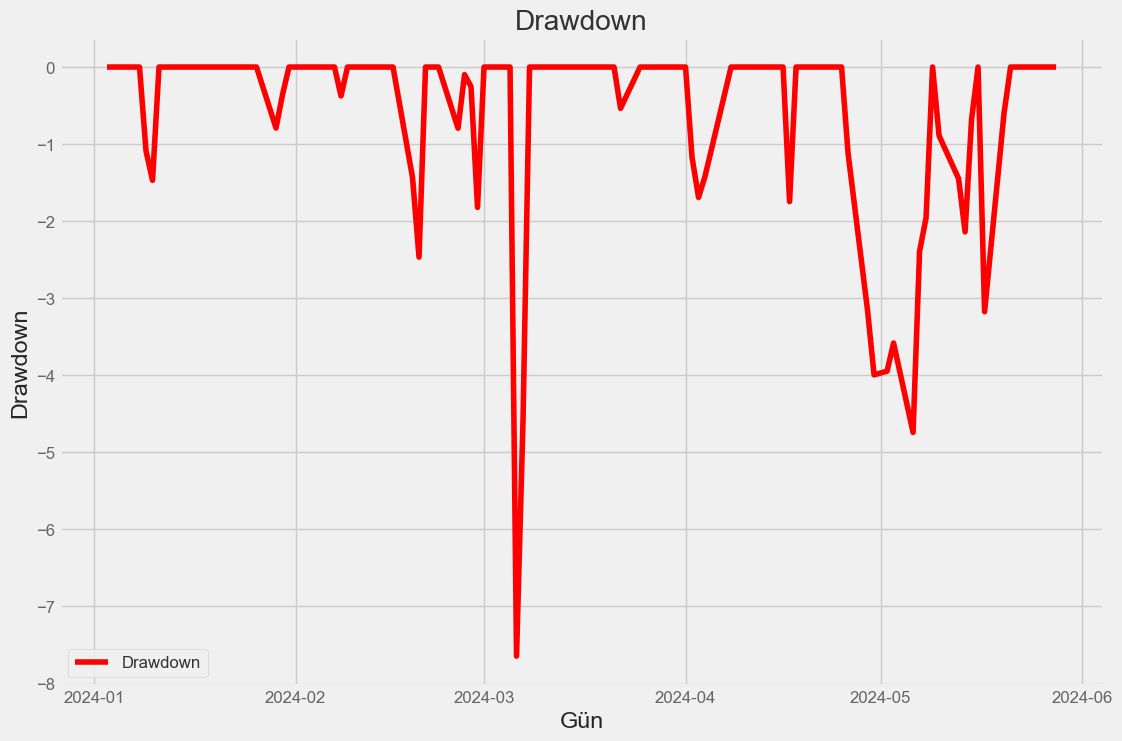

In [829]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Ağırlıklı Getiri"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [478]:
feature_importance = model.get_feature_importance(type='FeatureImportance')

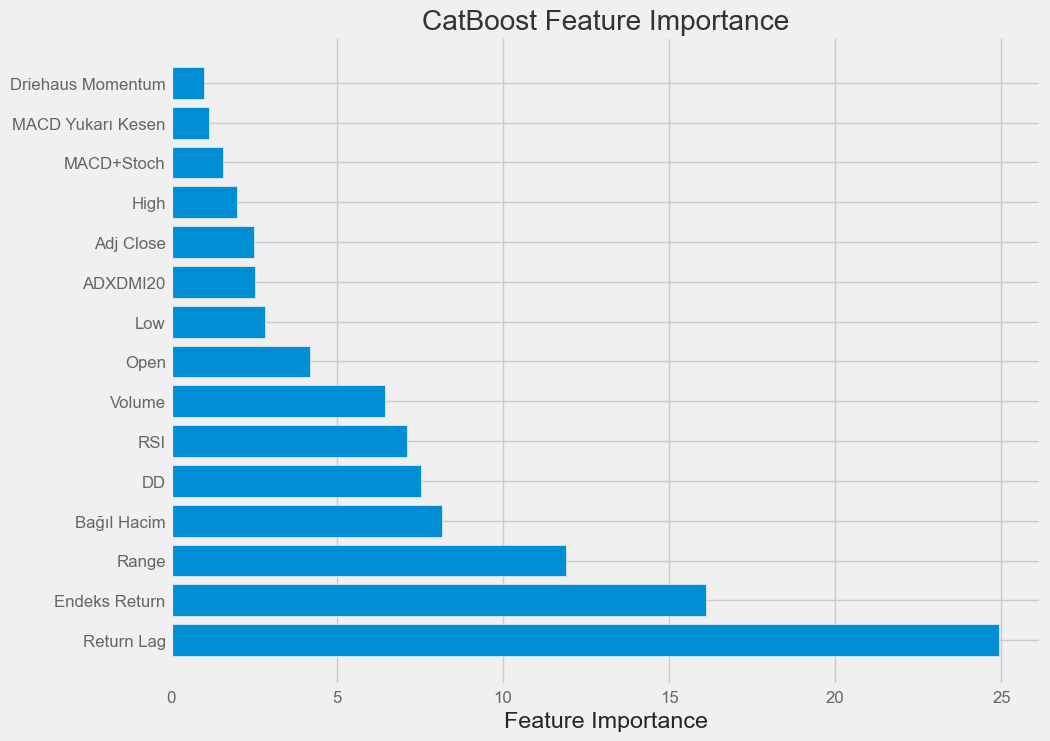

In [479]:
import catboost
feature_importance = model.get_feature_importance(type='FeatureImportance')
# Özellik isimlerini alın
feature_names = model.feature_names_

# Özellik önemlerini bir sözlükte saklayın
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Özellik önemlerine göre sıralayın
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.yticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [467]:
params ={'iterations': 363, 'depth': 9, 'learning_rate': 0.022966443559949937, 'random_strength': 13, 'bagging_temperature': 0.6758282260679829, 'border_count': 211, 'l2_leaf_reg': 18}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/bist100scaling.bin")

In [468]:
result = df.groupby('Hisse').apply(lambda x: x.iloc[2:])
result=result.droplevel(0)
result

,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,BB Low,BB Mid,BB Up,...,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,Return,Date,Endeks,Endeks Return,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-14.428858,2023-06-20,5251.600098,-4.089122,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-3.041543,2023-06-21,5186.799805,-1.233915,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-0.154202,2023-06-22,5428.299805,4.656050,-3.783383
2023-06-23,26.60,25.70,26.14,25.90,5.159935e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,0.000000,2023-06-23,5582.799805,2.846195,-0.154202
2023-06-26,26.40,25.84,25.90,25.90,3.380095e+08,A1CAP.IS,0,NaN,NaN,NaN,...,NaN,0,0,0,0,-0.694981,2023-06-26,5732.899902,2.688617,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0,6.757255,7.2810,7.804745,...,0.31,0,0,0,0,5.124654,2024-05-28,10677.500000,0.192362,0.697350
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0,6.757359,7.2815,7.805641,...,0.46,0,0,1,0,7.036536,2024-05-29,10479.200195,-1.857174,2.354571
2024-05-30,7.97,7.22,7.59,7.89,9.409127e+07,ZRGYO.IS,0,6.729725,7.3155,7.901275,...,0.75,0,1,1,1,3.422053,2024-05-30,10481.299805,0.020036,6.765900


In [469]:
from sklearn.preprocessing import MinMaxScaler
result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result.sort_index()
result=result[result["Hisse"].isin(bist100)]
features=["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen","High","Low","Open","Adj Close"]
scaler1=MinMaxScaler(feature_range=(0,1))
result[features]=scaler1.fit_transform(result[features])
scaler2=MinMaxScaler(feature_range=(0,1))
result["Return"]=scaler2.fit_transform(np.array(result["Return"]).reshape(-1,1))
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc[:"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_test=test.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_val=val.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_train=X_train[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen","High","Low","Open","Adj Close"]]
X_test=X_test[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen","High","Low","Open","Adj Close"]]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [470]:
tahminler=pd.DataFrame(scaler2.inverse_transform(np.array(test["Return"]).reshape(-1,1)))
tahminler=tahminler.set_index(X_test.index)
tahminler["Tahmin"]=scaler2.inverse_transform(np.array(model.predict(X_test)).reshape(-1,1))
tahminler.columns=["Gerçek","Tahmin"]
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Hisse"].isin(bist100)]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2).diff().dropna()
100*((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1)

Date
2024-01-02     0.156818
2024-01-03     1.280085
2024-01-04     3.190279
2024-01-05     5.682792
2024-01-08     5.737304
                ...    
2024-05-24    76.765628
2024-05-27    77.701789
2024-05-28    77.624696
2024-05-29    75.789119
2024-05-30    77.584970
Name: Gerçek, Length: 103, dtype: float64

In [471]:
indexler=df.index.unique()
top_5_rows1=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.4
top_5_rows2=top_5_rows.copy()
top_5_rows2["Gerçek"]-=0.08
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)
top_5_rows2=top_5_rows2.droplevel(level=0)

In [ ]:
window_size=range(2,21)
vars=[]
top_5_rows["Var"]=0
size=[]
toplamkar=[]
import pandas as pd
for window in window_size:
   for index, group in top_5_rows.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-window:]
              getiriler=window_data.pct_change(window-1)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
   veri=top_5_rows[top_5_rows["Var"]>0]
   metrik=veri["Var"]
   veri["Metrik"]=metrik
   veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
   veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
   topkar=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
   returns=topkar.diff().dropna()
   sharpe=(topkar.iloc[-1])/returns.std()
   toplamkar.append(topkar.iloc[-1])
   size.append(window)
   print("Window:{} Kar:{} Sharpe:{}".format(window,topkar.iloc[-1],sharpe))
optimizer=pd.DataFrame()
optimizer["Window Size"]=size
optimizer["Return"]=toplamkar
optimizer=optimizer.sort_values(by="Return",ascending=False)
optimizer

In [492]:

vars=[]
top_5_rows["Var"]=0

for index, group in top_5_rows.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-10:]
              getiriler=window_data.pct_change(9)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows[top_5_rows["Var"]>0]
metrik=veri["Var"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar=100*((np.cumprod(1+((veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2]/2))/100))-1)
returns=(veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2]/2).diff().dropna()
topkar

Date
2024-01-02     0.560856
2024-01-03     1.663461
2024-01-04     3.549898
2024-01-05     5.568394
2024-01-08     4.593488
                ...    
2024-05-24    95.953539
2024-05-27    97.518820
2024-05-28    97.034883
2024-05-29    94.355892
2024-05-30    97.444533
Name: Ağırlıklı Getiri, Length: 103, dtype: float64

In [474]:

vars=[]
top_5_rows1["Var"]=0

for index, group in top_5_rows1.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-10:]
              getiriler=window_data.pct_change(9)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows1.loc[(top_5_rows1["Hisse"]==hisse) & (top_5_rows1.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows1[top_5_rows1["Var"]>0]
metrik=veri["Var"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar1=100*((np.cumprod(1+((veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2]/2))/100))-1)
topkar1

Date
2024-01-02     0.360856
2024-01-03     1.260547
2024-01-04     2.936986
2024-01-05     4.737660
2024-01-08     3.560951
                ...    
2024-05-24    60.934729
2024-05-27    61.898410
2024-05-28    61.177949
2024-05-29    58.664132
2024-05-30    60.868243
Name: Ağırlıklı Getiri, Length: 103, dtype: float64

In [475]:

vars=[]
top_5_rows2["Var"]=0

for index, group in top_5_rows2.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-10:]
              getiriler=window_data.pct_change(9)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows2.loc[(top_5_rows1["Hisse"]==hisse) & (top_5_rows2.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows2[top_5_rows2["Var"]>0]
metrik=veri["Var"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar2=100*((np.cumprod(1+((veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2]/2))/100))-1)
topkar2

Date
2024-01-02     0.520856
2024-01-03     1.582814
2024-01-04     3.427122
2024-01-05     5.401853
2024-01-08     4.386324
                ...    
2024-05-24    88.393556
2024-05-27    89.823091
2024-05-28    89.282080
2024-05-29    86.632787
2024-05-30    89.524042
Name: Ağırlıklı Getiri, Length: 103, dtype: float64

In [476]:
endeks=yf.download(tickers="XU100.IS",start="2023-12-29")
endeks["Getiri"]=0
for i in range(len(endeks)):
    endeks["Getiri"].iloc[i]=100*((endeks["Adj Close"].iloc[i]/endeks["Adj Close"].iloc[0])-1)
endeks=endeks.fillna(0)


[*********************100%%**********************]  1 of 1 completed


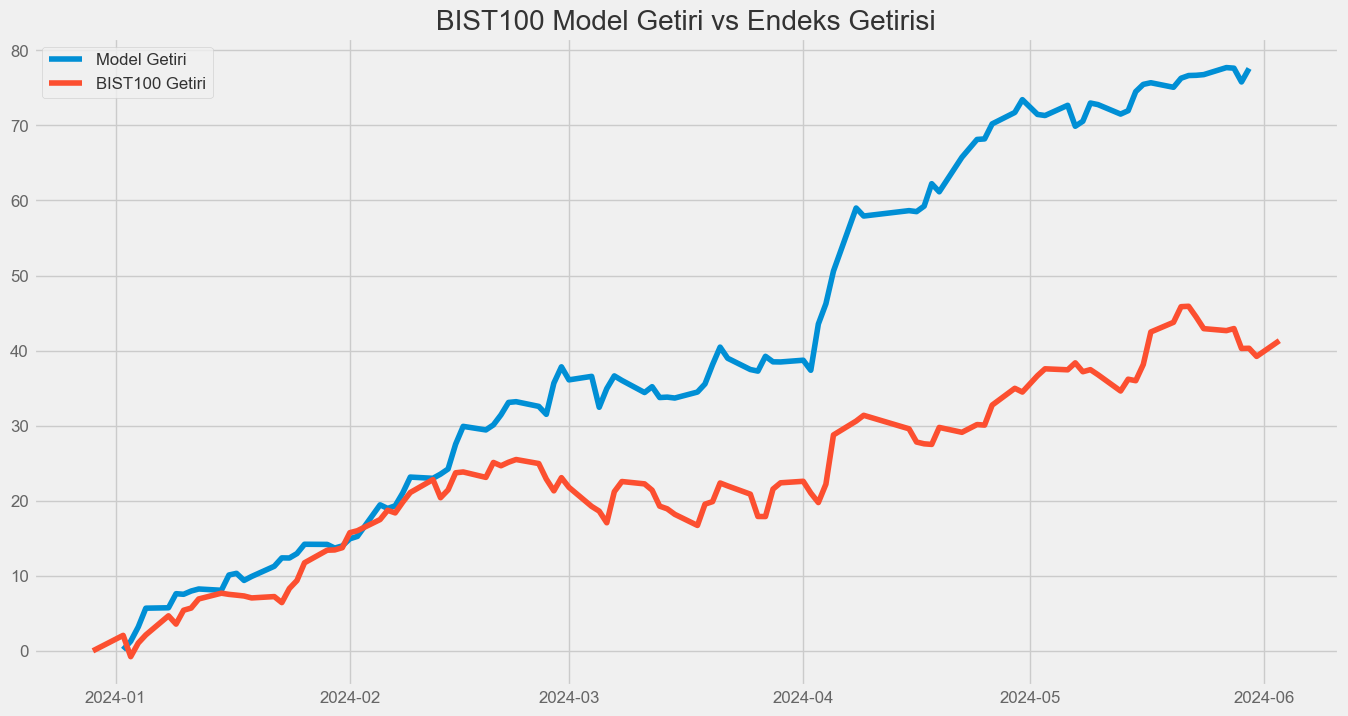

In [482]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("BIST100 Model Getiri vs Endeks Getirisi")
plt.plot(100*((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1),label="Model Getiri")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

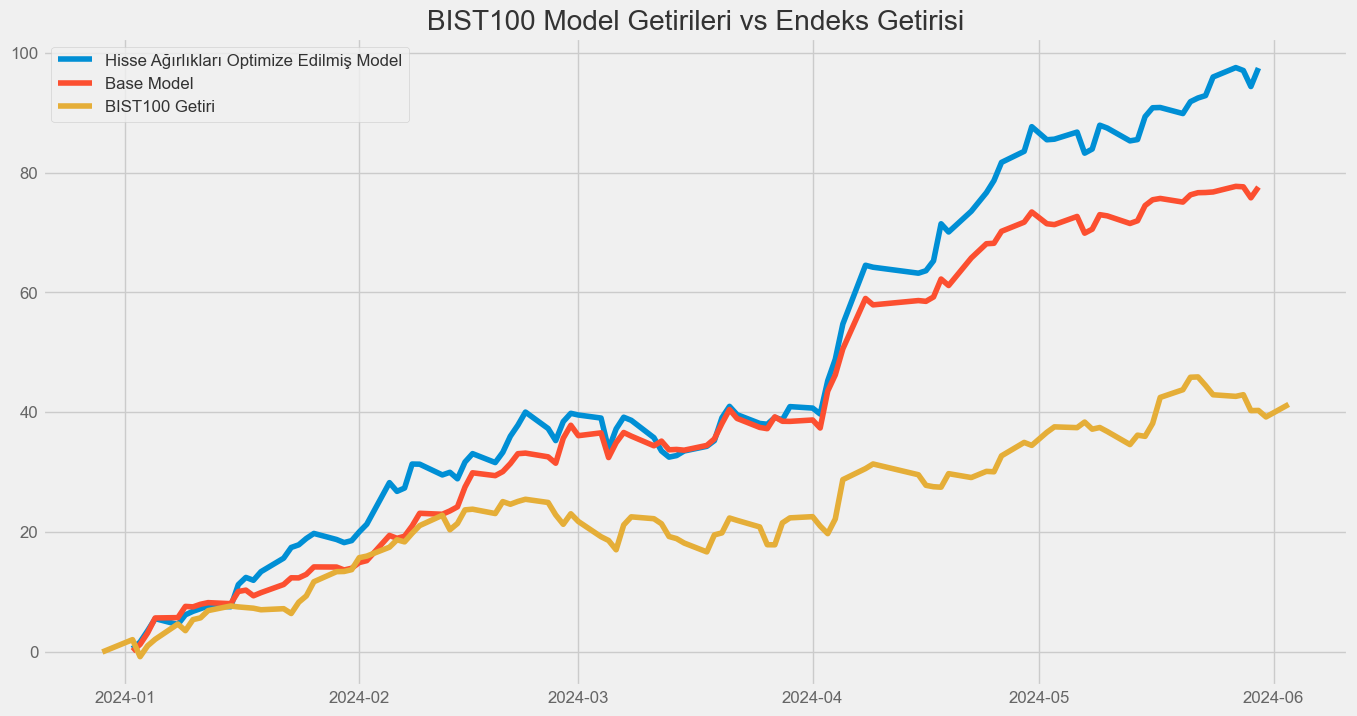

In [484]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("BIST100 Model Getirileri vs Endeks Getirisi")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(100*((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1),label="Base Model")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

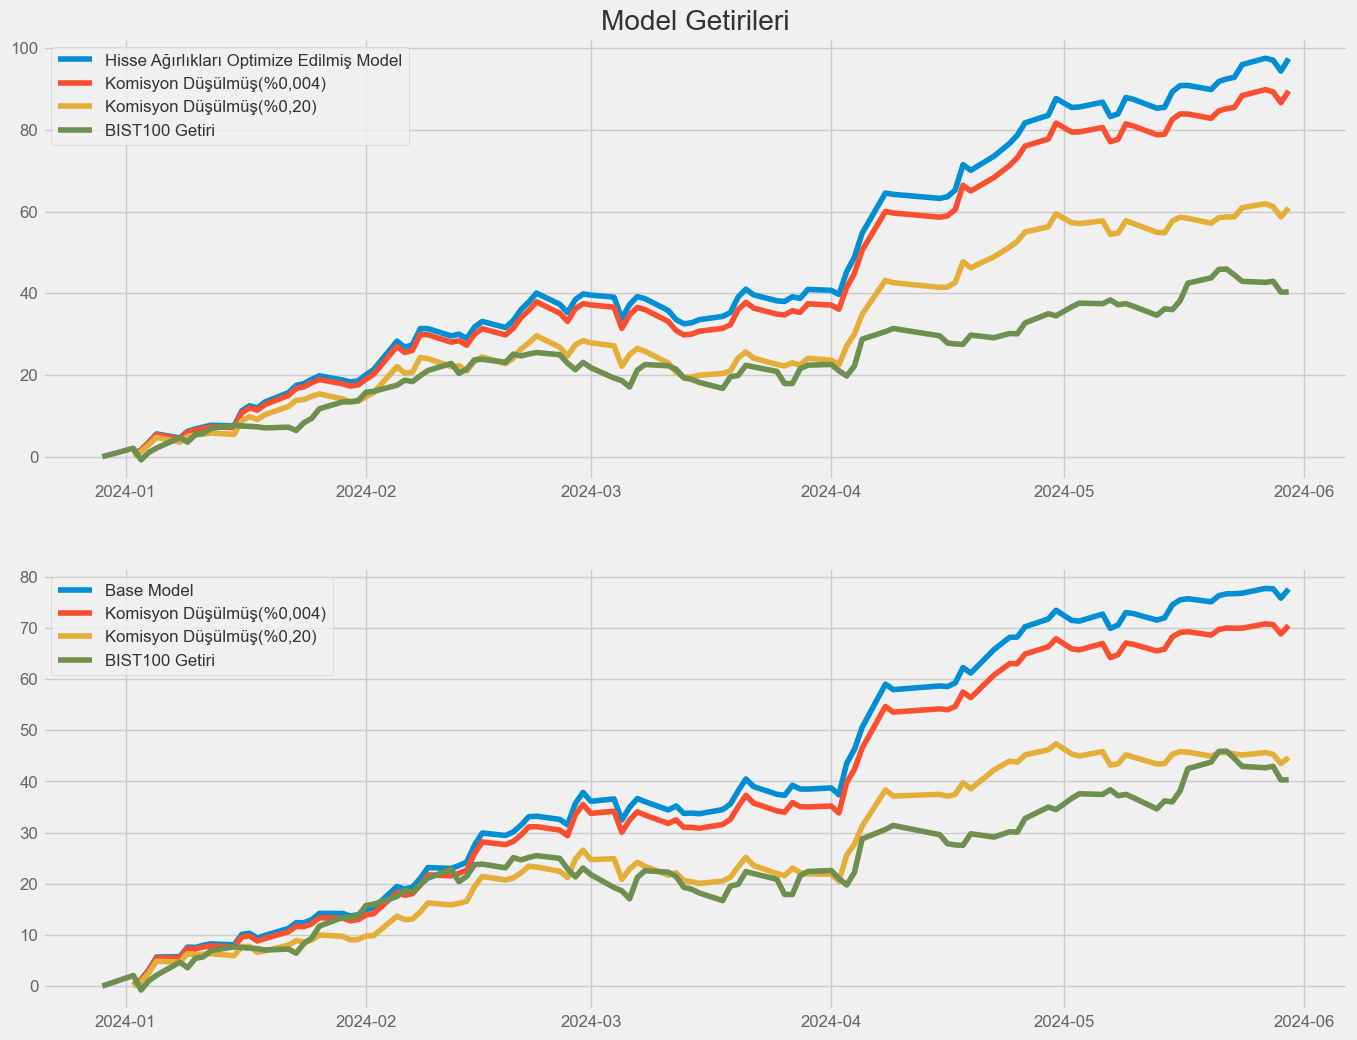

In [490]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.title("Model Getirileri")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(topkar2,label="Komisyon Düşülmüş(%0,004)")
plt.plot(topkar1,label="Komisyon Düşülmüş(%0,20)")
plt.plot(endeks["Getiri"].loc[:"2024-05-30"],label="BIST100 Getiri")

plt.legend()
plt.subplot(2,1,2)
plt.plot(100*((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1),label="Base Model")
plt.plot(100*((np.cumprod(1+((top_5_rows2.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1),label="Komisyon Düşülmüş(%0,004)")
plt.plot(100*((np.cumprod(1+((top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1),label="Komisyon Düşülmüş(%0,20)")
plt.plot(endeks["Getiri"].loc[:"2024-05-30"],label="BIST100 Getiri")
plt.legend()




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'DOAS.IS'),
  Text(0, 1, 'BERA.IS'),
  Text(0, 2, 'TTKOM.IS'),
  Text(0, 3, 'AKFGY.IS'),
  Text(0, 4, 'ALFAS.IS'),
  Text(0, 5, 'MIATK.IS'),
  Text(0, 6, 'SOKM.IS'),
  Text(0, 7, 'ALBRK.IS'),
  Text(0, 8, 'ZOREN.IS'),
  Text(0, 9, 'VAKBN.IS'),
  Text(0, 10, 'TABGD.IS'),
  Text(0, 11, 'EGEEN.IS'),
  Text(0, 12, 'BFREN.IS'),
  Text(0, 13, 'BIMAS.IS'),
  Text(0, 14, 'YKBNK.IS'),
  Text(0, 15, 'ENERY.IS'),
  Text(0, 16, 'MGROS.IS'),
  Text(0, 17, 'KCAER.IS'),
  Text(0, 18, 'ASELS.IS'),
  Text(0, 19, 'BRYAT.IS'),
  Text(0, 20, 'TAVHL.IS'),
  Text(0, 21, 'TURSG.IS'),
  Text(0, 22, 'PGSUS.IS'),
  Text(0, 23, 'AKFYE.IS'),
  Text(0, 24, 'TTRAK.IS'),
  Text(0, 25, 'AKBNK.IS'),
  Text(0, 26, 'KCHOL.IS'),
  Text(0, 27, 'GARAN.IS'),
  Text(0, 28, 'TCELL.IS'),
  Text(0, 29, 'ANSGR.IS')])

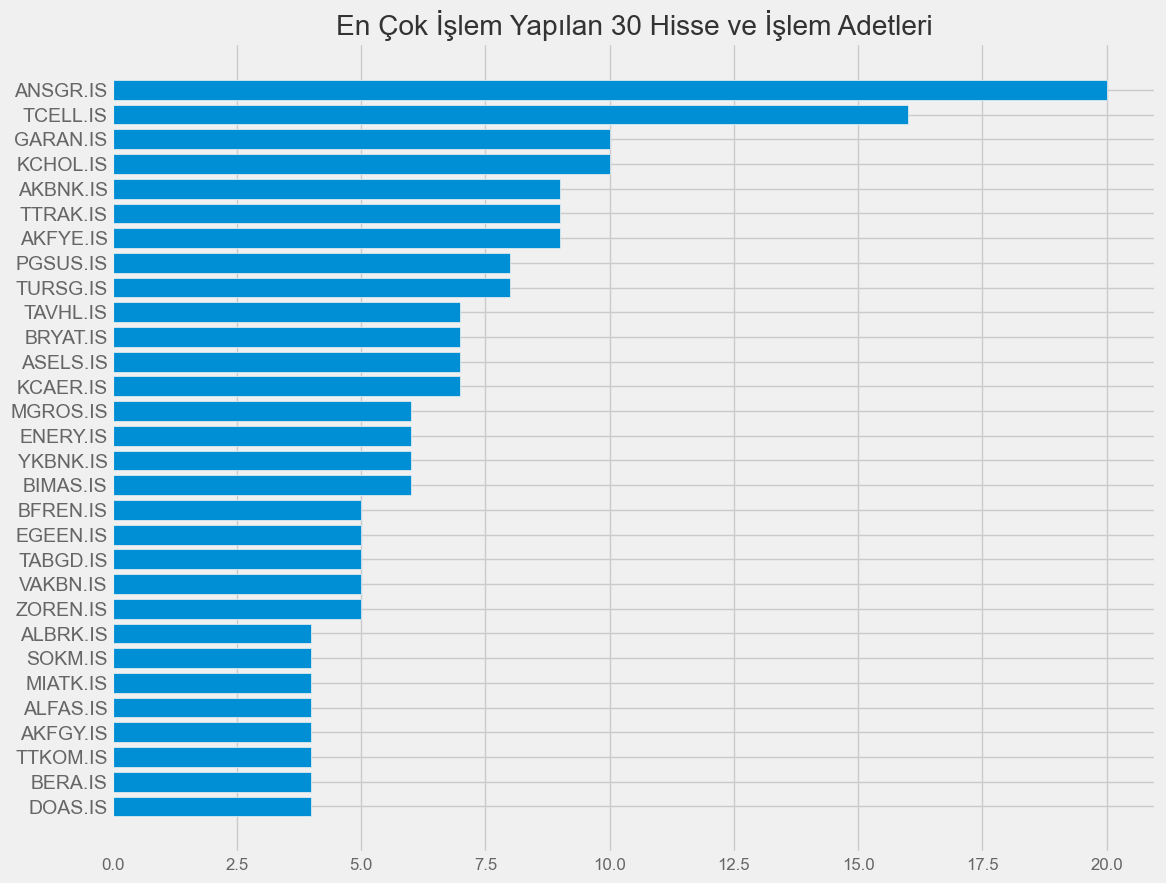

In [493]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(veri["Hisse"].value_counts().sort_values().tail(30).index,veri["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [494]:
veri["Para"]=100000*veri["Ağırlık"]
veri["Fiyat"]=0
for i in range(len(veri)):
    hisse=veri["Hisse"].iloc[i]
    time=pd.to_datetime(veri.index[i])
    fiyat=df[df["Hisse"]==hisse].loc[time]["Adj Close"]
    veri["Fiyat"].iloc[i]=fiyat
veri["Lot"]=veri["Para"]//veri["Fiyat"]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'AKCNS.IS'),
  Text(0, 1, 'SAHOL.IS'),
  Text(0, 2, 'ALFAS.IS'),
  Text(0, 3, 'TAVHL.IS'),
  Text(0, 4, 'KOZAL.IS'),
  Text(0, 5, 'BERA.IS'),
  Text(0, 6, 'KCHOL.IS'),
  Text(0, 7, 'AHGAZ.IS'),
  Text(0, 8, 'VESTL.IS'),
  Text(0, 9, 'AGROT.IS'),
  Text(0, 10, 'MIATK.IS'),
  Text(0, 11, 'AKSEN.IS'),
  Text(0, 12, 'PGSUS.IS'),
  Text(0, 13, 'SASA.IS'),
  Text(0, 14, 'TKFEN.IS'),
  Text(0, 15, 'TTKOM.IS'),
  Text(0, 16, 'SOKM.IS'),
  Text(0, 17, 'ASELS.IS'),
  Text(0, 18, 'TURSG.IS'),
  Text(0, 19, 'VAKBN.IS'),
  Text(0, 20, 'GARAN.IS'),
  Text(0, 21, 'KCAER.IS'),
  Text(0, 22, 'AKFYE.IS'),
  Text(0, 23, 'YKBNK.IS'),
  Text(0, 24, 'AKFGY.IS'),
  Text(0, 25, 'ALBRK.IS'),
  Text(0, 26, 'ZOREN.IS'),
  Text(0, 27, 'AKBNK.IS'),
  Text(0, 28, 'TCELL.IS'),
  Text(0, 29, 'ANSGR.IS')])

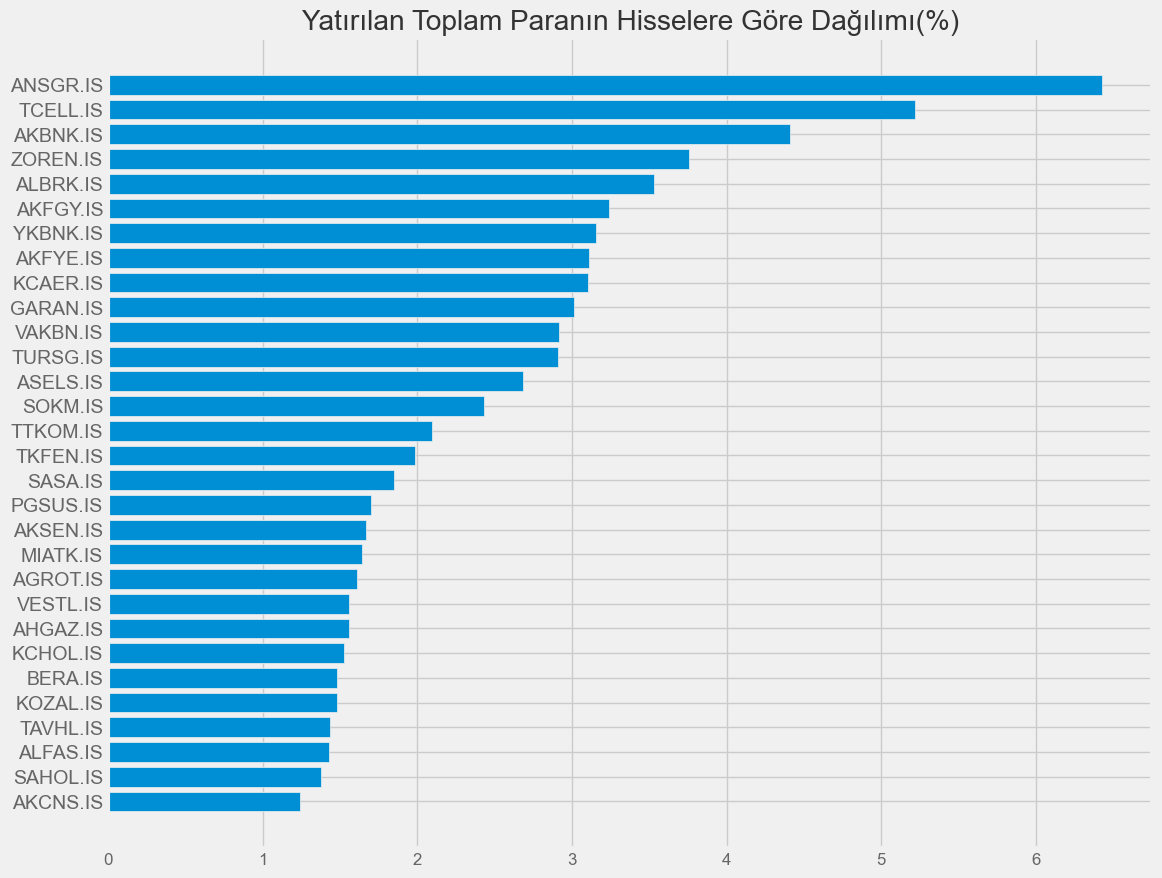

In [495]:
ağırlıklar=((100*(veri.loc[:"2024-05-30"].groupby('Hisse')["Para"].sum().sort_values(ascending=True)/veri.loc[:"2024-05-30"]["Para"].sum())))
plt.figure(figsize=(12,10))
plt.title("Yatırılan Toplam Paranın Hisselere Göre Dağılımı(%)")
plt.barh(ağırlıklar.tail(30).index,ağırlıklar.tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [509]:
endeks["Return"]=(endeks["Adj Close"]/endeks["Adj Close"].shift(1))-1
endeks=endeks.loc[:"2024-05-30"]
endeks

,Open,High,Low,Close,Adj Close,Volume,Getiri,Return
Date,,,,,,,,
2023-12-29,7415.299805,7510.399902,7415.299805,7470.200195,7470.200195,2664606500,0.000000,NaN
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,2.062858,0.020629
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-0.779098,-0.027845
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,1.038789,0.018322
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,2.121764,0.010718
...,...,...,...,...,...,...,...,...
2024-05-24,10784.200195,10810.700195,10661.400391,10676.700195,10676.700195,2234118100,42.923883,-0.010730
2024-05-27,10701.200195,10758.900391,10584.599609,10657.000000,10657.000000,2655557300,42.660166,-0.001845
2024-05-28,10678.799805,10721.200195,10589.700195,10677.500000,10677.500000,2872255400,42.934590,0.001924


In [520]:
returns=veri.loc[:"2024-05-30"].groupby("Date")["Ağırlıklı Getiri"].sum()/2
returns=returns/100
returns=pd.DataFrame(returns)
returns.columns=["Getiri"]
returns["Kar"]=0
returns["Kar"]=np.where(returns["Getiri"]>0,1,0)
returns

,Getiri,Kar
Date,,
2024-01-02,0.005609,1
2024-01-03,0.010965,1
2024-01-04,0.018556,1
2024-01-05,0.019493,1
2024-01-08,-0.009235,0
...,...,...
2024-05-24,0.016112,1
2024-05-27,0.007988,1
2024-05-28,-0.002450,0


In [522]:
endeks["Kar"]=0
endeks["Kar"]=np.where(endeks["Return"]>0,1,0)


In [525]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kazanma serisi uzunluğu:", ortalama)

Ortalama kazanma serisi uzunluğu: 3.090909090909091


In [529]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return kaybetme_serileri



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", ortalama)

Ortalama kaybetme serisi uzunluğu: [1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 4, 3, 1, 2, 2, 1, 1, 1, 2, 1, 2]


In [533]:
returns["Getiri"].std()

0.015736957835282672

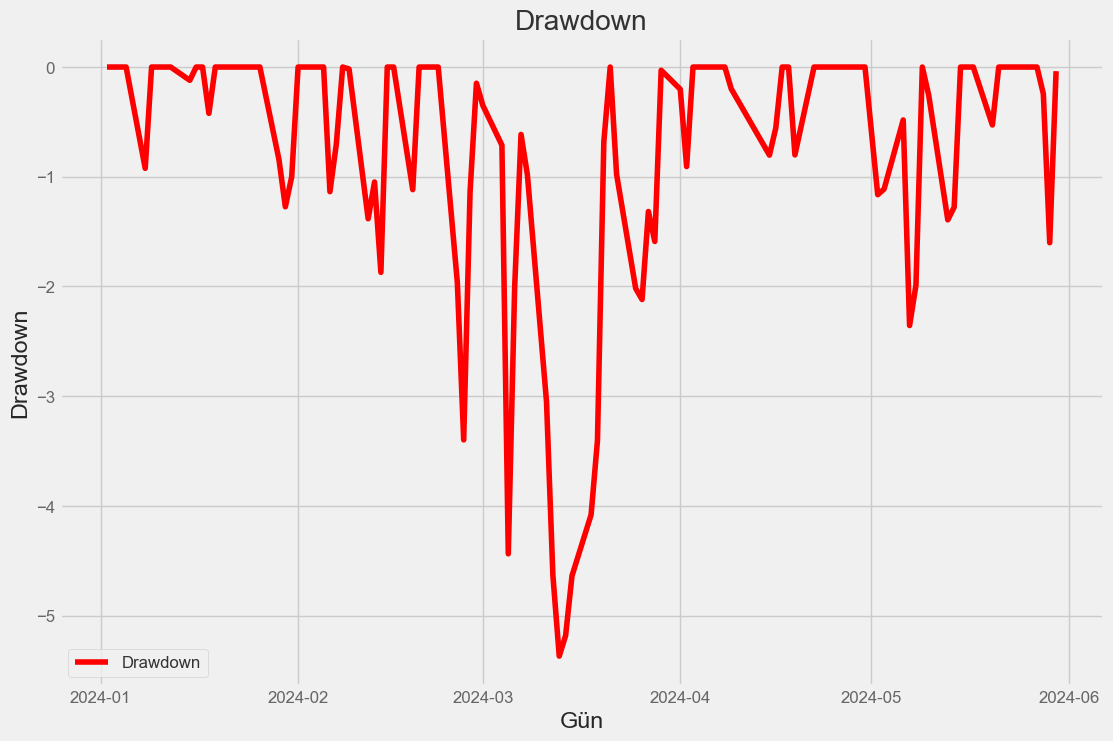

In [535]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Getiri"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
returns=veri.loc[:"2024-05-30"].groupby("Date")["Ağırlıklı Getiri"].sum()/2
returns=returns/100
qs.reports.full(returns=returns,benchmark="XU100.IS")

In [662]:
veri.loc[:"2024-05-30"].groupby("Hisse")["Gerçek"].sum().sort_values(ascending=False).head(20)

Hisse
KCAER.IS    52.355647
AKBNK.IS    29.956741
AGROT.IS    26.064053
ANSGR.IS    20.300268
ALFAS.IS    19.657006
AKFYE.IS    19.368490
TCELL.IS    19.049765
BRYAT.IS    18.067577
KCHOL.IS    17.581402
VAKBN.IS    16.172952
BFREN.IS    15.362874
DOAS.IS     13.371582
ENERY.IS    12.757479
TTKOM.IS    12.661266
ASELS.IS    12.552115
VESTL.IS    12.379929
YKBNK.IS     9.629944
SOKM.IS      9.142481
TURSG.IS     8.937543
TKFEN.IS     8.215772
Name: Gerçek, dtype: float64

In [671]:
veri[veri["Hisse"]=="ASELS.IS"].index

DatetimeIndex(['2024-02-16', '2024-02-19', '2024-02-21', '2024-02-22',
               '2024-02-23', '2024-02-26', '2024-04-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [688]:
alımlar=['2024-02-16', '2024-02-19', '2024-02-21',   '2024-04-26']
satımlar=['2024-02-19', '2024-02-21', '2024-02-27',  '2024-04-29']

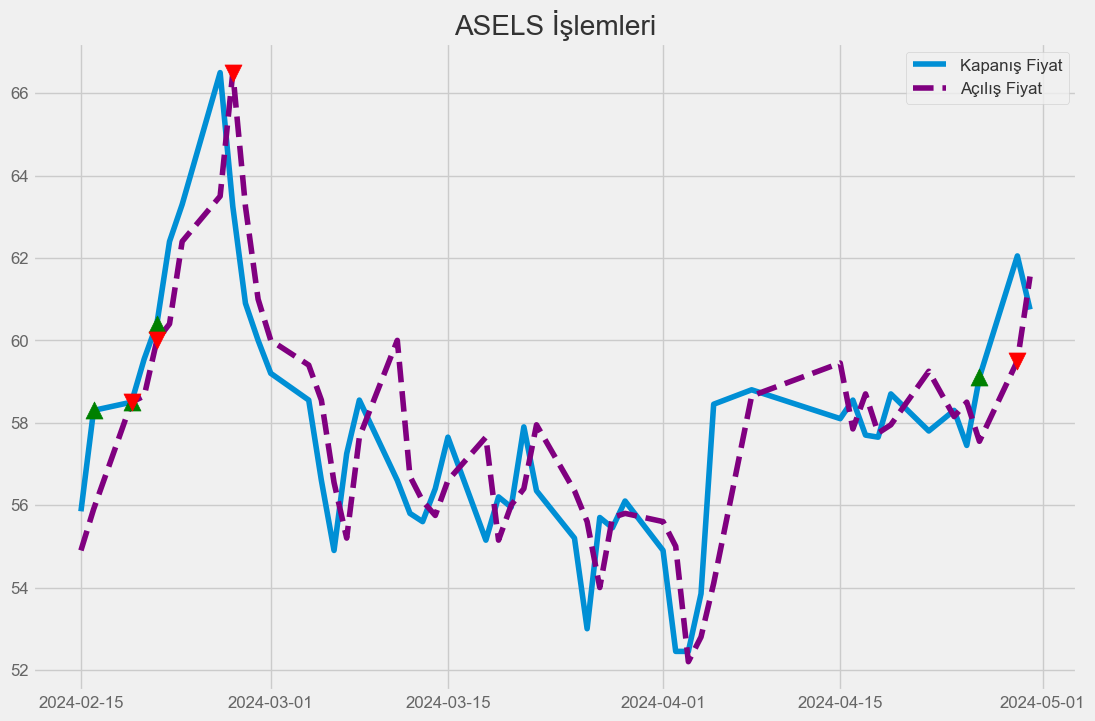

In [689]:
plt.figure(figsize=(12,8))
plt.title("ASELS İşlemleri")
plt.plot(df[df["Hisse"]=="ASELS.IS"]["Adj Close"].loc["2024-02-15":"2024-04-30"],label="Kapanış Fiyat")
plt.plot(df[df["Hisse"]=="ASELS.IS"]["Open"].loc["2024-02-15":"2024-04-30"],"--",color="purple",label="Açılış Fiyat")
plt.scatter(x=alımlar,y=df[df["Hisse"]=="ASELS.IS"].loc[alımlar]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=satımlar,y=df[df["Hisse"]=="ASELS.IS"].loc[satımlar]["Open"],marker="v",s=150,color="red",zorder=4)
plt.legend()

In [658]:
alımlar=['2024-01-22', '2024-02-02', '2024-02-16', '2024-02-20',
               '2024-02-22', '2024-04-08', '2024-04-15']
satımlar=['2024-01-24', '2024-02-06', '2024-02-19', '2024-02-22',
               '2024-02-26', '2024-04-15', '2024-04-17']

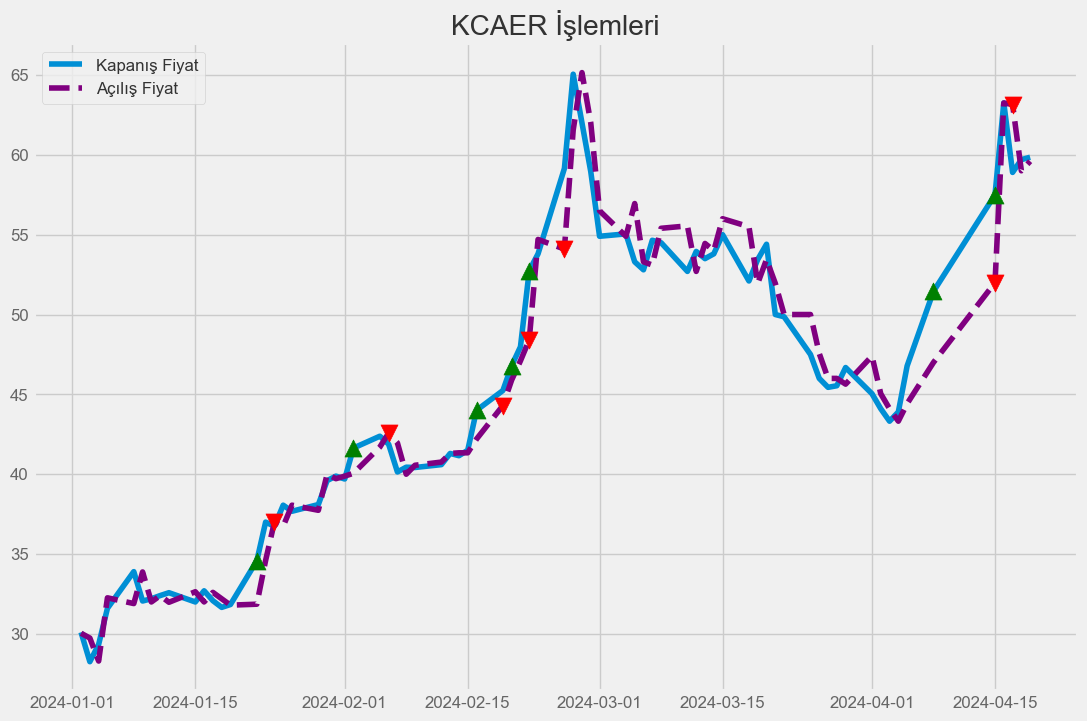

In [659]:
plt.figure(figsize=(12,8))
plt.title("KCAER İşlemleri")
plt.plot(df[df["Hisse"]=="KCAER.IS"]["Adj Close"].loc["2024-01-02":"2024-04-20"],label="Kapanış Fiyat")
plt.plot(df[df["Hisse"]=="KCAER.IS"]["Open"].loc["2024-01-02":"2024-04-20"],"--",color="purple",label="Açılış Fiyat")
plt.scatter(x=alımlar,y=df[df["Hisse"]=="KCAER.IS"].loc[alımlar]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=satımlar,y=df[df["Hisse"]=="KCAER.IS"].loc[satımlar]["Open"],marker="v",s=150,color="red",zorder=3)
plt.legend()

In [644]:
alımlar=['2024-01-05', '2024-01-25', '2024-02-05']
satımlar=['2024-01-08', '2024-01-29', '2024-02-07']

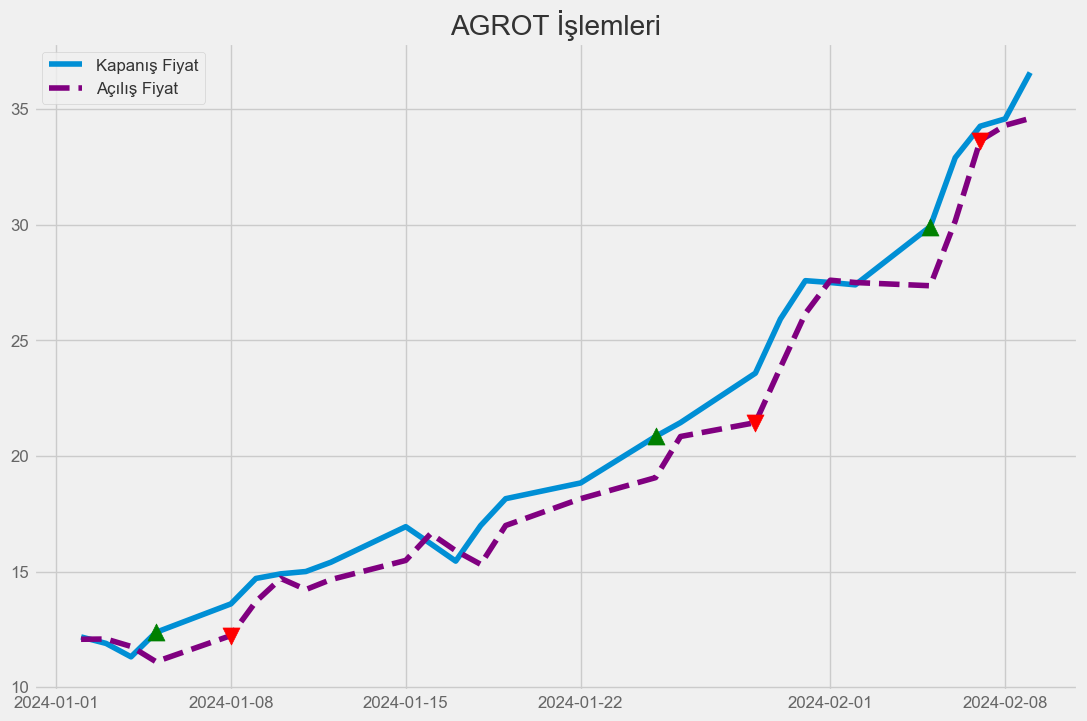

In [645]:
plt.figure(figsize=(12,8))
plt.title("AGROT İşlemleri")
plt.plot(df[df["Hisse"]=="AGROT.IS"]["Adj Close"].loc["2024-01-02":"2024-02-10"],label="Kapanış Fiyat")
plt.plot(df[df["Hisse"]=="AGROT.IS"]["Open"].loc["2024-01-02":"2024-02-10"],"--",color="purple",label="Açılış Fiyat")
plt.scatter(x=alımlar,y=df[df["Hisse"]=="AGROT.IS"].loc[alımlar]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=satımlar,y=df[df["Hisse"]=="AGROT.IS"].loc[satımlar]["Open"],marker="v",s=150,color="red",zorder=3)
plt.legend()

In [637]:
alımlar=['2024-03-28', '2024-04-01', '2024-04-03', 
               '2024-04-08', '2024-04-15', '2024-04-17']
satımlar=['2024-04-01', '2024-04-03', '2024-04-05', 
               '2024-04-15', '2024-04-17', '2024-04-19']

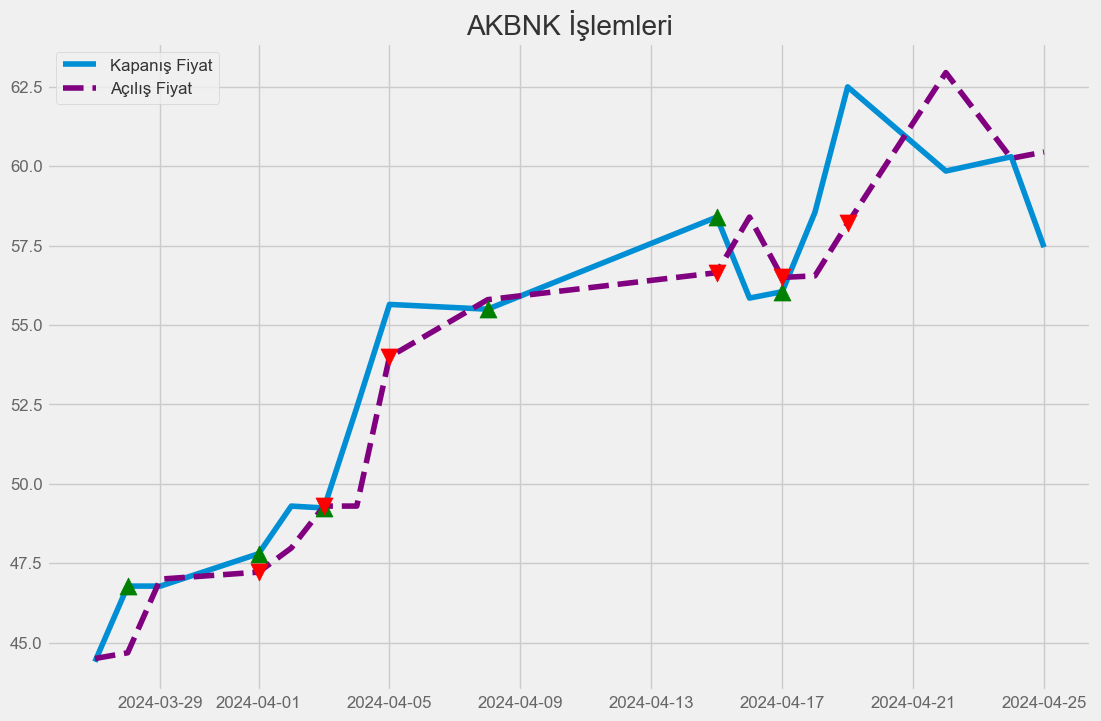

In [639]:
plt.figure(figsize=(12,8))
plt.title("AKBNK İşlemleri")
plt.plot(df[df["Hisse"]=="AKBNK.IS"]["Adj Close"].loc["2024-03-27":"2024-04-25"],label="Kapanış Fiyat")
plt.plot(df[df["Hisse"]=="AKBNK.IS"]["Open"].loc["2024-03-27":"2024-04-25"],"--",color="purple",label="Açılış Fiyat")
plt.scatter(x=alımlar,y=df[df["Hisse"]=="AKBNK.IS"].loc[alımlar]["Adj Close"],marker="^",s=150,color="green",zorder=3)
plt.scatter(x=satımlar,y=df[df["Hisse"]=="AKBNK.IS"].loc[satımlar]["Open"],marker="v",s=150,color="red",zorder=3)
plt.legend()

In [466]:
params={'iterations': 571,
 'depth': 5,
 'learning_rate': 0.05514261151828995,
 'random_strength': 4,
 'bagging_temperature': 0.9572252022114495,
 'border_count': 59,
 'l2_leaf_reg': 20}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/bist100model.bin")

In [ ]:
result = df.groupby('Hisse').apply(lambda x: x.iloc[2:])
result=result.droplevel(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result.sort_index()
result=result[result["Hisse"].isin(bist100)]
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc[:"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_test=test.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_val=val.drop(["Hisse","Return","Endeks","Tavan Kontrol"],axis=1)
X_train=X_train[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
X_test=X_test[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [ ]:
tahminler=pd.DataFrame()
tahminler["Gerçek"]=test["Return"]
tahminler["Tahmin"]=model.predict(X_test)
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Hisse"].isin(bist100)]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(2, columns=['Tahmin'])).dropna()
100*((np.cumprod(1+((top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2))/100))-1)

In [ ]:
indexler=df.index.unique()
top_5_rows1=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.4
top_5_rows2=top_5_rows.copy()
top_5_rows2["Gerçek"]-=0.08
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)
top_5_rows2=top_5_rows2.droplevel(level=0)

In [ ]:

vars=[]
top_5_rows["Var"]=0

for index, group in top_5_rows.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-10:]
              getiriler=window_data.pct_change(9)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows[top_5_rows["Var"]>0]
metrik=veri["Var"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar=100*((np.cumprod(1+((veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2]/2))/100))-1)
returns=(veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2]/2).diff().dropna()
topkar